# How popular are different social movements over time?

LSE DS105A - Data for Data Science (2024/25)

**Date**: 18/11/24

**Authors**: Gemi Banjo, Amelia Dunn

**Objective**:🌟 Further process the GDELT all_process_data to get popularity of different social movements or events over time.

In [4]:
import os
import json
import requests
import glob
import datetime

import pandas as pd

from dotenv import load_dotenv
from tqdm.notebook import tqdm
tqdm.pandas()

from IPython.display import Image

import sqlite3
from sqlalchemy import create_engine, text


## 1. Processing GDELT data 

In [5]:
df = pd.read_csv('../../data/raw/2014_protest_data.csv')
df.head()

,GLOBALEVENTID,SQLDATE,MonthYear,Year,FractionDate,Actor1Code,Actor1Name,Actor1CountryCode,Actor1KnownGroupCode,Actor1EthnicCode,...,Actor2Geo_FeatureID,ActionGeo_Type,ActionGeo_FullName,ActionGeo_CountryCode,ActionGeo_ADM1Code,ActionGeo_Lat,ActionGeo_Long,ActionGeo_FeatureID,DATEADDED,SOURCEURL
0,281510593,20140101,201401,2014,2014.0027,TUR,TURKEY,TUR,NaN,NaN,...,NaN,2,"Alaska, United States",US,USAK,61.3850,-152.2680,AK,20140101,"Zaman website, Istanbul/BBC Monitoring/(c) BBC"
1,281515425,20140101,201401,2014,2014.0027,USA,UNITED STATES,USA,NaN,NaN,...,NaN,3,"Upper Providence, Pennsylvania, United States",US,USPA,39.9551,-75.4230,1197544,20140101,http://www.montgomerynews.com/articles/2014/01...
2,281515426,20140101,201401,2014,2014.0027,USA,UNITED STATES,USA,NaN,NaN,...,NaN,3,"Valley Park, Pennsylvania, United States",US,USPA,40.1093,-75.1052,1207721,20140101,http://www.montgomerynews.com/articles/2014/01...
3,281515427,20140101,201401,2014,2014.0027,USA,ALASKA,USA,NaN,NaN,...,NaN,2,"Alaska, United States",US,USAK,61.3850,-152.2680,AK,20140101,"Zaman website, Istanbul/BBC Monitoring/(c) BBC"
4,281518684,20140101,201401,2014,2014.0027,USA,ALASKA,USA,NaN,NaN,...,-740445,2,"Alaska, United States",US,USAK,61.3850,-152.2680,AK,20140101,"Zaman website, Istanbul/BBC Monitoring/(c) BBC"


Justification for each of the columns chosen:

| Heading | Justification |
| :---: | :---: |
| Global Event ID | To have an exact numeric value to categorise the event. |
| SQL Date | So that we can evaluate when social movements peaked and for how long. |
| Actor 1 Country Code | To make sure that the event is local to the USA. |
| Goldstein Scale | To measure how cooperative or conflictual interactions between countries are. |
| Num Mentions | To get a measure of how much interaction different social movements have. |
| Avg Tone | To get the average sentiment of all documents that mention a specific event. |

In [6]:
data_filepath = '../../data/raw/'
file_list = glob.glob(f"{data_filepath}/*_protest_data.csv")

# Concatenate all DataFrames
combined_df = pd.concat([pd.read_csv(file, dtype={'SQLDATE': str}) for file in file_list], ignore_index=True)

# Getting dates into the correct form for consistency

combined_df['SQLDATE'] = pd.to_datetime(combined_df['SQLDATE'].astype(str), format='%Y%m%d').dt.strftime('%Y-%m-%d')

# Filtering then renaming to get relevant data and improve clarity
relevant_columns = ['GLOBALEVENTID', 'SQLDATE', 'Actor1CountryCode', 'SOURCEURL', 'GoldsteinScale', 'NumMentions', 'AvgTone', 'Actor1Name', 'Actor2Name']
protest_data = combined_df[relevant_columns].copy()
protest_data.rename(columns={'GLOBALEVENTID': 'EventID', 'SQLDATE': 'Date', 'Actor1CountryCode': 'RelevantCountry', 'Actor1Name': 'PrimaryActor', 'Actor2Name': 'SecondaryActor'}, inplace= True)

protest_data

,EventID,Date,RelevantCountry,SOURCEURL,GoldsteinScale,NumMentions,AvgTone,PrimaryActor,SecondaryActor
0,896070561,1920-01-01,NaN,https://www.independentsentinel.com/dems-bash-...,-6.5,1,-5.100830,IMAM,THE US
1,896070562,1920-01-01,NaN,https://www.independentsentinel.com/dems-bash-...,-6.5,4,-5.100830,IMAM,THE US
2,896070814,1920-01-01,USA,https://www.independentsentinel.com/dems-bash-...,-6.5,1,-5.100830,UNITED STATES,THE US
3,896070815,1920-01-01,USA,https://www.independentsentinel.com/dems-bash-...,-6.5,2,-5.100830,AMERICAN,THE US
4,896077841,1920-01-01,USA,http://www.kmaj1440.com/news/more-than-20-mill...,-6.5,10,-4.942966,KANSAS,GOVERNOR
...,...,...,...,...,...,...,...,...,...
96449,227056775,2012-12-31,BEL,NaN,-6.5,2,1.325758,WATERLOO,UNITED STATES
96450,227062227,2012-12-31,NaN,NaN,-6.5,10,1.518027,POLICE,NaN
96451,227084788,2012-12-31,MAR,NaN,-6.5,1,2.639442,RABAT,GOVERNMENT
96452,227104011,2012-12-31,USA,NaN,-6.5,6,1.325758,UNITED STATES,SENATOR


In [7]:
protest_data.to_csv('../../data/processed/all_protest_data.csv', index=False)

## 2. Further processing using SQLite

Load CSV and Connect to SQLite Database

In [8]:
# Load the CSV file into a Pandas DataFrame
csv_filepath = '../../data/processed/all_protest_data.csv'  
data = pd.read_csv(csv_filepath)

# Connect to SQLite database (or create it if it doesn't exist)
db_path = '../../data/processed/social_movements.db'  # Database file name
conn = sqlite3.connect(db_path)

# Cursor to execute SQL commands
cursor = conn.cursor()


Create a Table in SQLite

In [9]:
# Drop the existing table
conn.execute("DROP TABLE IF EXISTS SocialMovements;")

# SQL command to create a table with a composite primary key
create_table_query = """
CREATE TABLE IF NOT EXISTS SocialMovements (
    EventID INTEGER,
    Date TEXT,
    RelevantCountry TEXT,
    SOURCEURL TEXT,
    GoldsteinScale REAL,
    NumMentions INTEGER,
    AvgTone REAL,
    PrimaryActor TEXT,
    SecondaryActor TEXT,
    PRIMARY KEY (EventID, Date)
);
"""

# Execute the query to create the table
conn.execute(create_table_query)
conn.commit()

print("Table 'SocialMovements' created successfully with a composite primary key.")


Table 'SocialMovements' created successfully with a composite primary key.


In [10]:
# Insert data from DataFrame to SQLite
data.to_sql('SocialMovements', conn, if_exists='replace', index=False)

print(f"Data successfully inserted into {db_path}.")


Data successfully inserted into ../../data/processed/social_movements.db.


test success with a simple query:

In [11]:
# Example query
query = "SELECT * FROM SocialMovements LIMIT 5;"
result = pd.read_sql_query(query, conn)

print(result)


     EventID        Date RelevantCountry  \
0  896070561  1920-01-01            None   
1  896070562  1920-01-01            None   
2  896070814  1920-01-01             USA   
3  896070815  1920-01-01             USA   
4  896077841  1920-01-01             USA   

                                           SOURCEURL  GoldsteinScale  \
0  https://www.independentsentinel.com/dems-bash-...            -6.5   
1  https://www.independentsentinel.com/dems-bash-...            -6.5   
2  https://www.independentsentinel.com/dems-bash-...            -6.5   
3  https://www.independentsentinel.com/dems-bash-...            -6.5   
4  http://www.kmaj1440.com/news/more-than-20-mill...            -6.5   

   NumMentions   AvgTone   PrimaryActor SecondaryActor  
0            1 -5.100830           IMAM         THE US  
1            4 -5.100830           IMAM         THE US  
2            1 -5.100830  UNITED STATES         THE US  
3            2 -5.100830       AMERICAN         THE US  
4           10 -4

In [12]:
conn.close()


## Investigating using SQLite:

*This is just some more checking and will be moved later into a seperate file

In [13]:
# Connect to the database
db_path = '../../data/processed/social_movements.db'
conn = sqlite3.connect(db_path)

In [14]:
# Predefined keywords for social movements
keywords = {
    'Black Lives Matter': ['blm', 'black-lives-matter'],
    'Me Too': ['me-too', 'metoo', 'me-too-movement'],
    'Climate Change': ['climate-change', 'global-warming'],
    'LGBTQ+ Rights': ['lgbtq', 'pride', 'gay-rights'],
    'Gun Control': ['gun-control', 'gun-violence', 'nra'],
    'Immigration': ['immigration', 'border', 'migrant', 'refugee'],
    'Women\'s Rights': ['women-rights', 'gender-equality', 'feminism'],
    'Native American Rights': ['native-american-rights', 'indigenous-rights', 'tribal-sovereignty'],
    'Healthcare Reform': ['healthcare-reform', 'obamacare', 'medicare-for-all'],
    'Workers\' Rights': ['labor-rights', 'union', 'workers-strike', 'minimum-wage'],
    'Education Reform': ['education-reform', 'student-loans', 'teacher-strike'],
    'Voting Rights': ['voting-rights', 'voter-suppression', 'election-reform'],
}


In [15]:
# Generate dynamic queries for each movement
movement_data = {}
for movement, terms in keywords.items():
    term_conditions = " OR ".join([f"SOURCEURL LIKE '%{term}%'" for term in terms])
    query = f"""
    SELECT 
        SUBSTR(Date, 1, 4) AS Year, 
        COUNT(*) AS TotalMentions, 
        AVG(GoldsteinScale) AS AvgGoldstein, 
        AVG(AvgTone) AS AvgTone
    FROM SocialMovements
    WHERE {term_conditions}
    GROUP BY Year
    ORDER BY Year;
    """
    movement_data[movement] = pd.read_sql_query(query, conn)


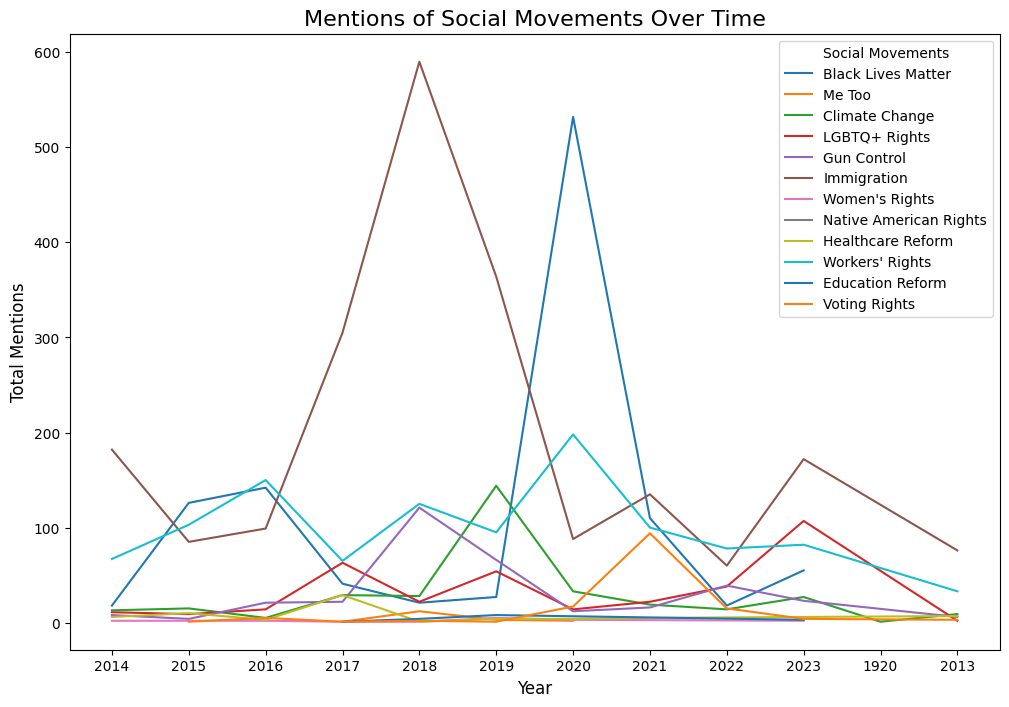

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 8))

for movement, data in movement_data.items():
    sns.lineplot(data=data, x='Year', y='TotalMentions', label=movement)

plt.title('Mentions of Social Movements Over Time', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Total Mentions', fontsize=12)
plt.legend(title="Social Movements")
plt.show()


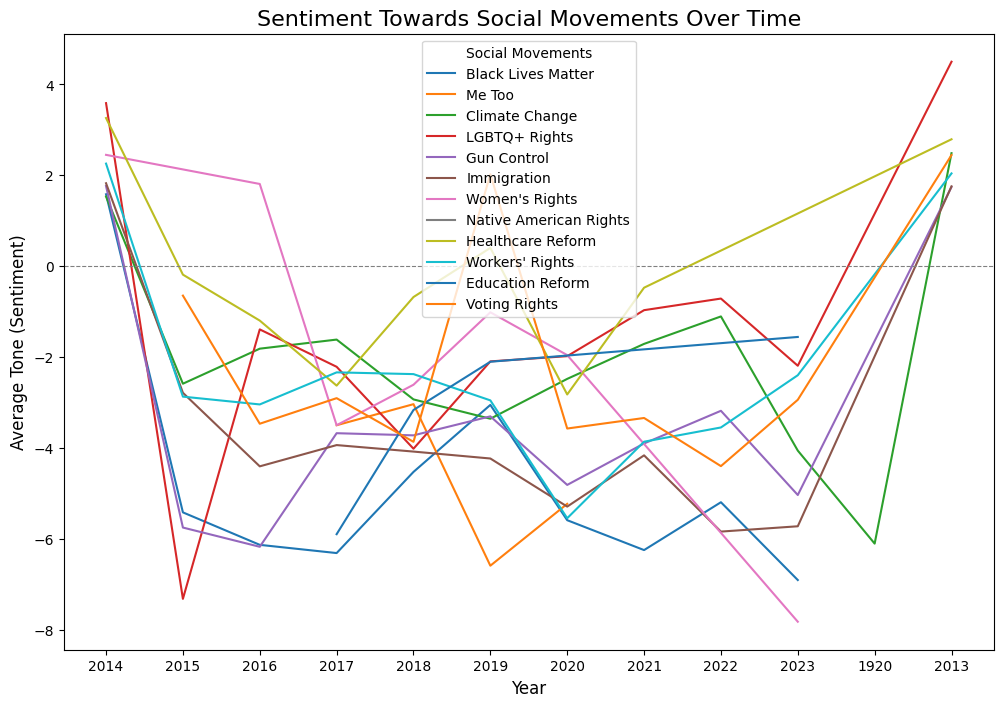

In [19]:
plt.figure(figsize=(12, 8))

for movement, data in movement_data.items():
    sns.lineplot(data=data, x='Year', y='AvgTone', label=movement)

plt.title('Sentiment Towards Social Movements Over Time', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Average Tone (Sentiment)', fontsize=12)
plt.legend(title="Social Movements")
plt.axhline(0, color='gray', linestyle='--', linewidth=0.8)
plt.show()


## Putting FRED into a database:

First, rename a column

In [20]:
csv_file = '../../data/processed/GDP_data.csv'
df = pd.read_csv('../../data/processed/GDP_data.csv')
df.rename(columns={'GDP (billions)': 'GDP_Billions'}, inplace=True)

df.to_csv(csv_file, index=False)

Then process into a database

In [21]:
# Load the FRED data from CSV into a DataFrame
# Load the CSV file into a Pandas DataFrame
csv_filepath = '../../data/processed/GDP_data.csv'  
data = pd.read_csv(csv_filepath)

# Connect to SQLite database (or create it if it doesn't exist)
db_path = '../../data/processed/social_movements.db'  
conn = sqlite3.connect(db_path)

# Drop the existing table if it exists
conn.execute("DROP TABLE IF EXISTS FRED;")

In [22]:
# SQL command to create a table with 'Date' as the primary key
create_table_query = """
CREATE TABLE IF NOT EXISTS FRED (
    Date TEXT PRIMARY KEY,
    GDP_Billions REAL
);
"""
conn.execute(create_table_query)

# Insert FRED data into the FRED table
data.to_sql('FRED', conn, if_exists='append', index=False)



95

In [23]:
# Verify data insertion
print("FRED Table:")
print(pd.read_sql_query("SELECT * FROM FRED;", conn))

FRED Table:
          Date  GDP_Billions
0   2023-01-01     22671.096
1   2022-01-01     22034.828
2   2021-01-01     21494.798
3   2020-01-01     20267.585
4   2019-01-01     20715.671
..         ...           ...
90  1933-01-01       877.431
91  1932-01-01       888.414
92  1931-01-01      1019.977
93  1930-01-01      1089.785
94  1929-01-01      1191.124

[95 rows x 2 columns]


In [24]:
conn.close()

# note from Gbemi

i stopped changing output directories from here cos i dont want to mess up code realting to smithsonian cos idk whats going on  - delete later

## Putting Smithsonian into a database:

In [20]:
# Load Smithsonian data
file_path = '../../Smithsonian/american_artworks_with_dates.csv' 
smithsonian_df = pd.read_csv(file_path)

# Clean and preprocess the data
# Fill missing ProductionYear values with 0 (or another default if preferred)
smithsonian_df['ProductionYear'].fillna(0, inplace=True)

# Convert ProductionYear to an integer (if it contains NaNs, convert them to a placeholder value like 0 first)
smithsonian_df['ProductionYear'] = smithsonian_df['ProductionYear'].astype(int)

# Connect to the SQLite database
db_file = '../data_amelia/processed/social_movements.db'  # Replace with your database name
conn = sqlite3.connect(db_file)


/tmp/ipykernel_528/334578865.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  smithsonian_df['ProductionYear'].fillna(0, inplace=True)


In [21]:
# Create the table with a composite primary key
create_table_query = """
CREATE TABLE IF NOT EXISTS SmithsonianArtworks (
    ID TEXT NOT NULL,
    Title TEXT,
    Type TEXT,
    Date TEXT,
    Topics TEXT,
    ProductionYear INTEGER NOT NULL,
    PRIMARY KEY (ID, ProductionYear)
);
"""
conn.execute(create_table_query)

In [22]:
# Insert data into the database
smithsonian_df.to_sql('SmithsonianArtworks', conn, if_exists='replace', index=False)

16938

In [23]:
# Verify the insertion
query = "SELECT * FROM SmithsonianArtworks LIMIT 5;"
result = pd.read_sql(query, conn)
print(result)


                                  ID                       Title  \
0  ld1-1643381040022-1643381068115-0  Governor for Steam Engines   
1  ld1-1643381040022-1643381068119-0                   Mousetrap   
2  ld1-1643381040022-1643381068106-0       Electrical Timer Bell   
3  ld1-1643381040022-1643381068107-0      Water Feed for Boilers   
4  ld1-1643381040022-1643381068114-1                    Windmill   

                              Type  Date        Topics  ProductionYear  
0  Smithsonian American Art Museum  1870  Patent model            1870  
1  Smithsonian American Art Museum  1870  Patent model            1870  
2  Smithsonian American Art Museum  1860  Patent model            1860  
3  Smithsonian American Art Museum  1880  Patent model            1880  
4  Smithsonian American Art Museum  1880  Patent model            1880  


In [24]:
# Close the database connection
conn.close()